In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from environments import OctorotorEnvSelector
from systems.pid_agent import PIDAgent
from multirotor.helpers import DataLog
from stable_baselines3 import PPO
from parameters import pid_params
from trajectories import nasa_wp, square_100, circle_100

In [2]:
best_agent = PPO.load('./saved_models/higher_actions_noZ/96') 

In [3]:
pid_parameters = pid_params()

In [4]:
best_params = {'steps_u':50, 'scaling_factor':1, 'window_distance':23, 'pid_parameters':pid_parameters}

In [5]:
env_selector = OctorotorEnvSelector()
square_wpts = np.array([[100,0,30], [100,100,30], [0,100,30], [0,0,30]])

In [6]:
def run_trajectory(env_selector, wind_ranges: np.ndarray, agent, params, waypts):
    env = env_selector.get_env("lstm", params, wind_ranges, waypts, start_alt=30, has_turbulence=True)
    env.wp_options = [waypts]
    env.base_env.fault_type = None
    done = False
    state = np.array(env.reset(), dtype=np.float32)
    log = DataLog(env.base_env.vehicle, 
                      other_vars=('reward','next_wp', 'disturbance_pred', 'disturbance', 'lstm_input', 'agent_actions', 'observations', 'wind_x', 'wind_y',
                                  'inertial_x', 'inertial_y'))
    inputs = []
    while not done:
        action = agent.predict(state, deterministic=True)[0]
        state, reward, done, info = env.step(action)
        state = np.array(state, dtype=np.float32)
        log.log(reward=reward, next_wp=env.base_env.next_waypt, disturbance_pred=env.base_env.disturbance_pred, 
                disturbance=env.base_env.disturbance, lstm_input=env.base_env.lstm_input, agent_actions=action,
                observations=env.base_env.observed_state, wind_x=env.base_env.wind_x, wind_y=env.base_env.wind_y, 
                inertial_x=env.base_env.vehicle.inertial_velocity[0], inertial_y=env.base_env.vehicle.inertial_velocity[1])
        inputs.append(np.array(env.base_env.lstm_input))
        

    log.done_logging()
    return log, info, np.array(inputs)

In [7]:
log, info, inputs = run_trajectory(env_selector, [(0,0), (12,12), (0,0)], best_agent, best_params, nasa_wp)

Text(0.5, 1.0, 'X and Y Position')

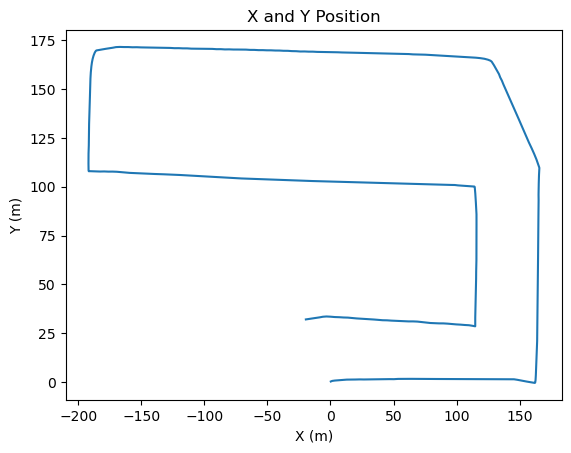

In [8]:
plt.plot(log.x, log.y)
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("X and Y Position")

Text(0, 0.5, 'Altitude (m)')

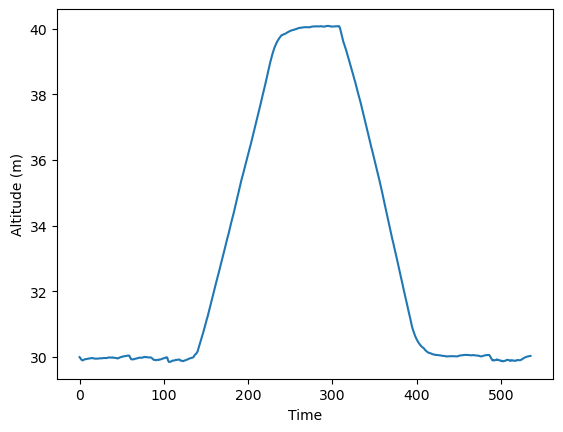

In [9]:
plt.plot(log.z)
plt.xlabel("Time")
plt.ylabel("Altitude (m)")